<a href="https://colab.research.google.com/github/mittshah2/Skin-Disease-Prediction-Web-Application/blob/master/HAM28_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as p
import PIL as pil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import seaborn as sns


# **Visualising Dataset**

In [5]:
meta=pd.read_csv('HAM10000_metadata.csv')
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [6]:
meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


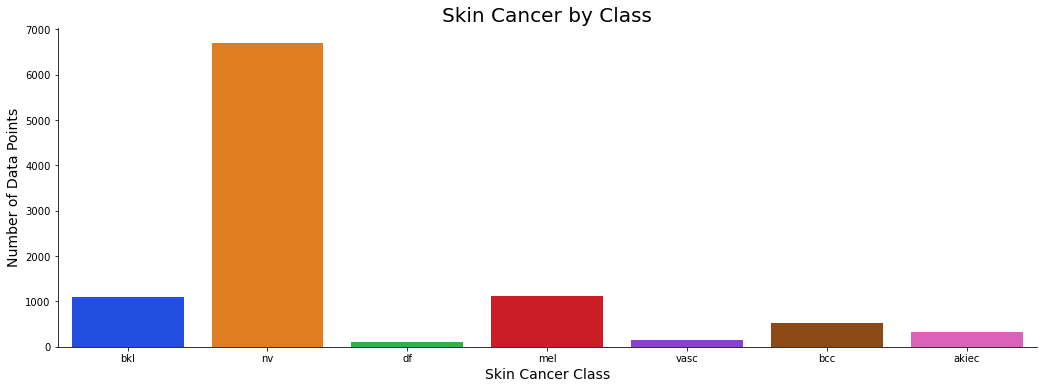

In [7]:
g = sns.catplot(x="dx", kind="count", palette='bright', data=meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Class', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)

This graph shows the dataset has a major problem of class imbalance.

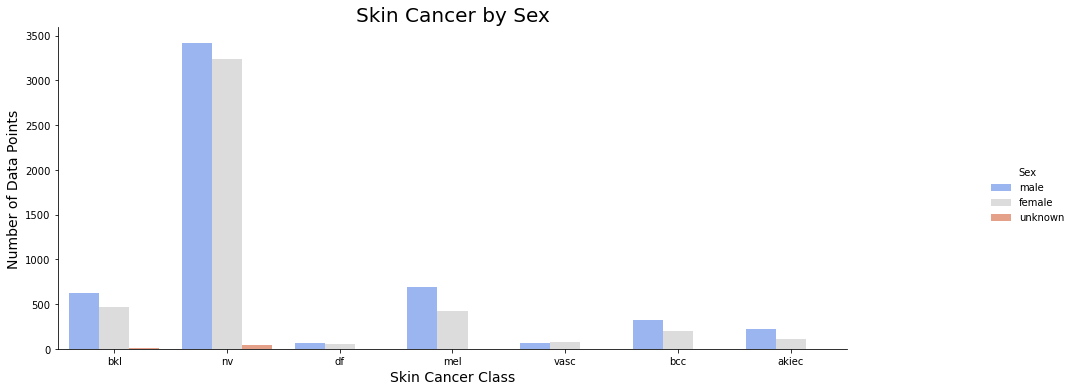

In [8]:
g = sns.catplot(x="dx", kind="count", hue="sex", palette='coolwarm', data=meta)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Sex', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Sex')

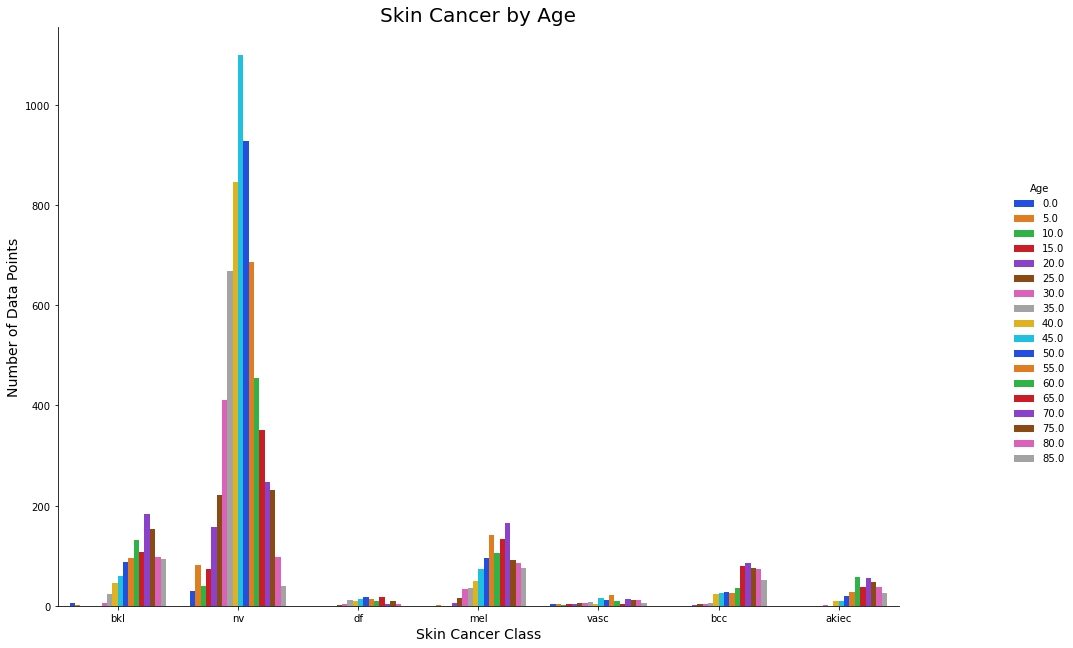

In [9]:
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=meta)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')

# **Extracting x and y from csv file**

In [11]:
df=pd.read_csv('hmnist_28_28_RGB.csv')
x=df.drop('label',axis=1)
y=df['label']
x=x.to_numpy()
x=x/255
y=to_categorical(y)

In [12]:
df['label'].value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

In [13]:
label={
    ' Actinic keratoses':0,
    'Basal cell carcinoma':1,
    'Benign keratosis-like lesions':2,
    'Dermatofibroma':3,
    'Melanocytic nevi':4,
    'Melanoma':5,
    'Vascular lesions':6
}

In [14]:
x=x.reshape(-1,28,28,3)

# **Spliiting into train test**

In [15]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.1,random_state=13,stratify=df['label'])

# **Image augmentation**

In [16]:
datagen=ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='nearest')

In [17]:
datagen.fit(xtrain)

# **Model**

In [18]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
def accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [19]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import RMSprop

model=Sequential()

model.add(Conv2D(64,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Conv2D(1024,(2,2),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Conv2D(1024,(1,1),input_shape=(28,28,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(7,activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=[accuracy])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 64)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 13, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 512)       131584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 512)        0         
 2D)                                                             
                                                        

In [20]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early=EarlyStopping(monitor='accuracy',patience=3)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=2, verbose=1, mode='min', min_lr=0.0001)

# **Training**

In [21]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
def accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [22]:
class_weights={0:1,1:1,2:1,3:1,4:0.5,5:1,6:1}

In [23]:
model.fit(xtrain,ytrain,epochs=30,validation_data=(xtest,ytest),callbacks=[reduce_lr,early],class_weight=class_weights)

Epoch 1/30
282/282 [==============================] - 89s 313ms/step - loss: 1.0600 - accuracy: 0.7808 - val_loss: 2.0872 - val_accuracy: 0.1098 - lr: 0.0010
Epoch 2/30
282/282 [==============================] - 88s 311ms/step - loss: 0.7807 - accuracy: 0.8239 - val_loss: 0.9802 - val_accuracy: 0.7834 - lr: 0.0010
Epoch 3/30
282/282 [==============================] - ETA: 0s - loss: 0.7207 - accuracy: 0.8376
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
282/282 [==============================] - 88s 312ms/step - loss: 0.7207 - accuracy: 0.8376 - val_loss: 0.9552 - val_accuracy: 0.8473 - lr: 0.0010
Epoch 4/30
282/282 [==============================] - 91s 323ms/step - loss: 0.6455 - accuracy: 0.8638 - val_loss: 0.7234 - val_accuracy: 0.8862 - lr: 5.0000e-04
Epoch 5/30
282/282 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.8710
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
282/282 [======================

# **Evaluation**


<AxesSubplot:>

<Figure size 1080x720 with 0 Axes>

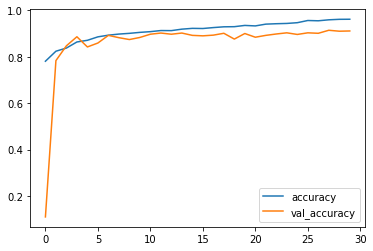

In [24]:
p.figure(figsize=(15,10))
loss=pd.DataFrame(model.history.history)
loss[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

<Figure size 1080x720 with 0 Axes>

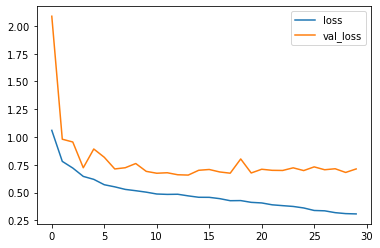

In [25]:
p.figure(figsize=(15,10))
loss[['loss','val_loss']].plot()

In [26]:
decode={
    0:'Actinic keratosis',
    1:'Basal cell carcinoma',
    2:'Benign keratosis-like lesions',
    3:'Dermatofibroma',
    4:'Melanocytic nevi',
    5:'Melanoma',
    6:'Vascular lesion'  
}

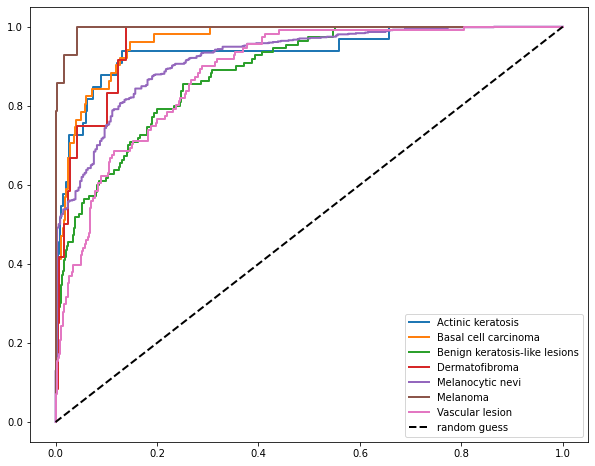

In [27]:
p.figure(figsize=(10,8))

pred=model.predict(xtest)

from sklearn.metrics import roc_curve,auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(ytest[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(7):
    p.plot(fpr[i],tpr[i],label=decode[i],linewidth=2)
p.plot([0, 1], [0, 1], 'k--', lw=2,label='random guess')
p.legend(loc="lower right")

In [31]:
from sklearn.metrics import classification_report,confusion_matrix

predictions=model.predict(xtest)

classes_x=np.argmax(predictions,axis=1)

check=[]
for i in range(len(ytest)):
  for j in range(7):
    if(ytest[i][j]==1):
      check.append(j)
check=np.asarray(check)
print(classification_report(check,classes_x))

              precision    recall  f1-score   support

           0       0.64      0.42      0.51        33
           1       0.60      0.61      0.60        51
           2       0.47      0.59      0.53       110
           3       0.38      0.25      0.30        12
           4       0.90      0.86      0.88       671
           5       1.00      0.71      0.83        14
           6       0.48      0.59      0.53       111

    accuracy                           0.76      1002
   macro avg       0.64      0.58      0.60      1002
weighted avg       0.78      0.76      0.77      1002

